# Set up

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler

# Dataset

In [2]:
df = pd.read_csv('__datasets/PJMW_hourly.csv')
df

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


In [3]:
df.drop_duplicates(subset = 'Datetime', inplace = True)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.asfreq('1H')
df.sort_index(inplace = True)
df.rename(columns = {'PJMW_MW': 'Target'}, inplace = True)
df.fillna({'Target': df['Target'].mean()}, inplace = True)
df

,Target
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


In [4]:
# Verify that a temporary index is complete
(df.index == pd.date_range(start = df.index.min(), end = df.index.max(), freq = df.index.freq)).all()

True

In [5]:
df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['week_of_year'] = pd.Index(df.index.isocalendar().week)
df['week_of_year'] = df['week_of_year'].astype(int)
df['day'] = df.index.day
df['day_of_year'] = df.index.dayofyear
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour
df

,Target,year,quarter,month,week_of_year,day,day_of_year,day_of_week,hour
Datetime,,,,,,,,,
2002-04-01 01:00:00,4374.0,2002,2,4,14,1,91,0,1
2002-04-01 02:00:00,4306.0,2002,2,4,14,1,91,0,2
2002-04-01 03:00:00,4322.0,2002,2,4,14,1,91,0,3
2002-04-01 04:00:00,4359.0,2002,2,4,14,1,91,0,4
2002-04-01 05:00:00,4436.0,2002,2,4,14,1,91,0,5
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,2018,3,8,31,2,214,3,20
2018-08-02 21:00:00,6496.0,2018,3,8,31,2,214,3,21
2018-08-02 22:00:00,6325.0,2018,3,8,31,2,214,3,22


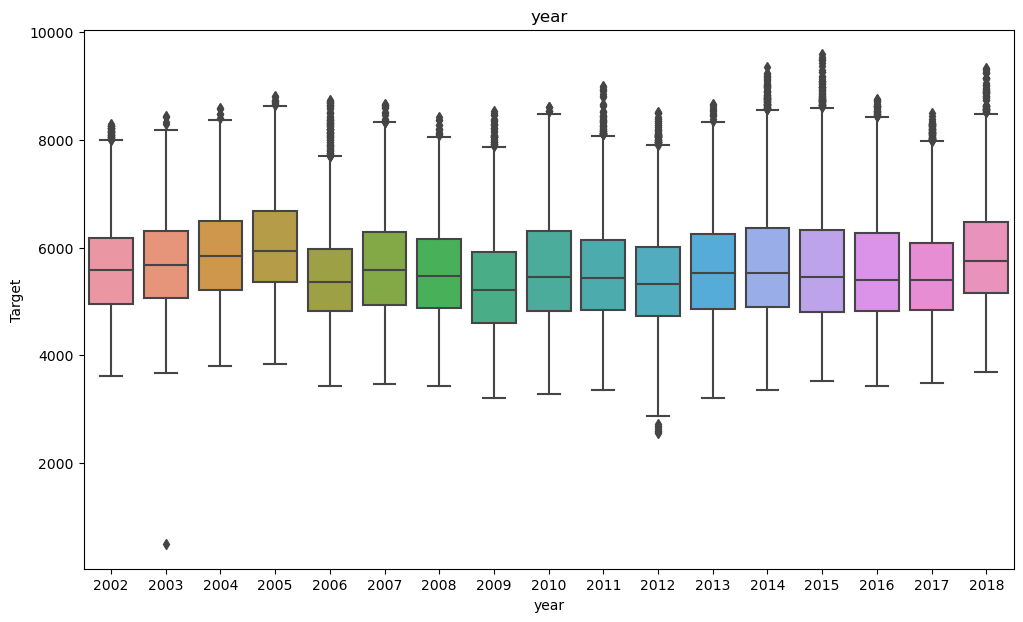

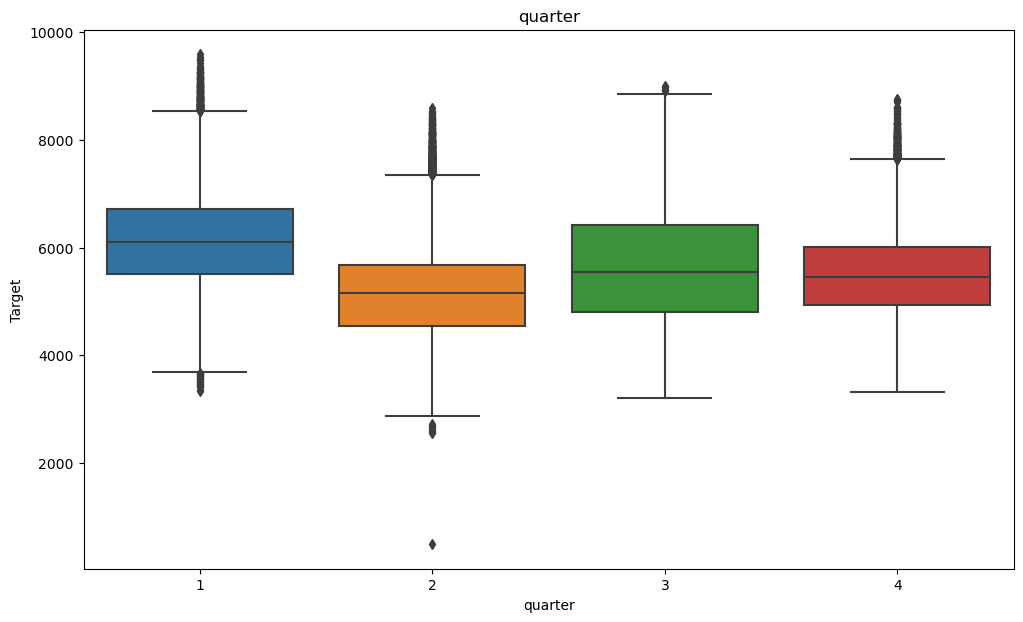

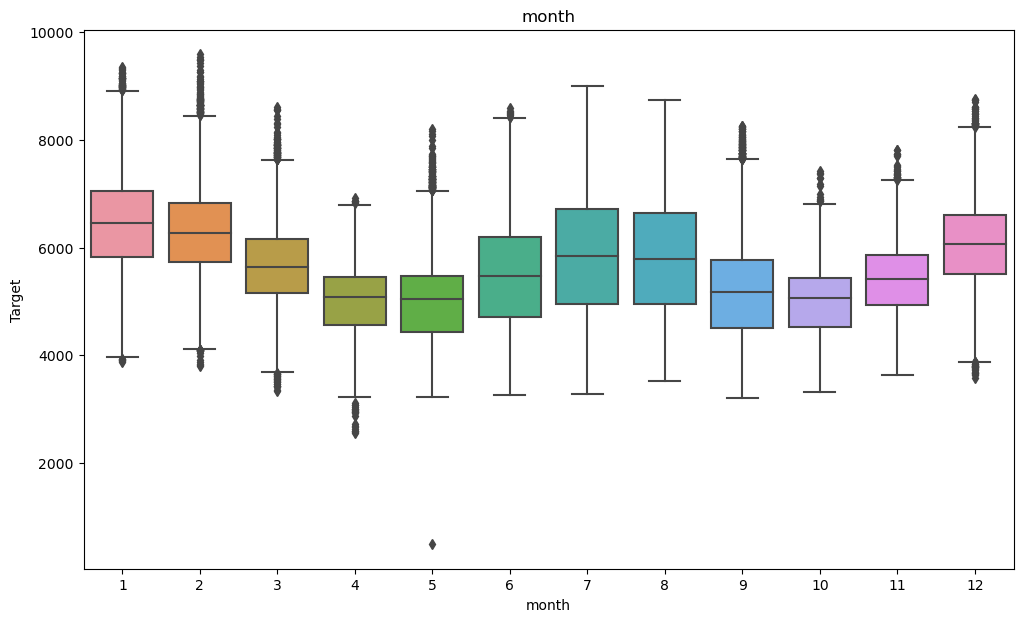

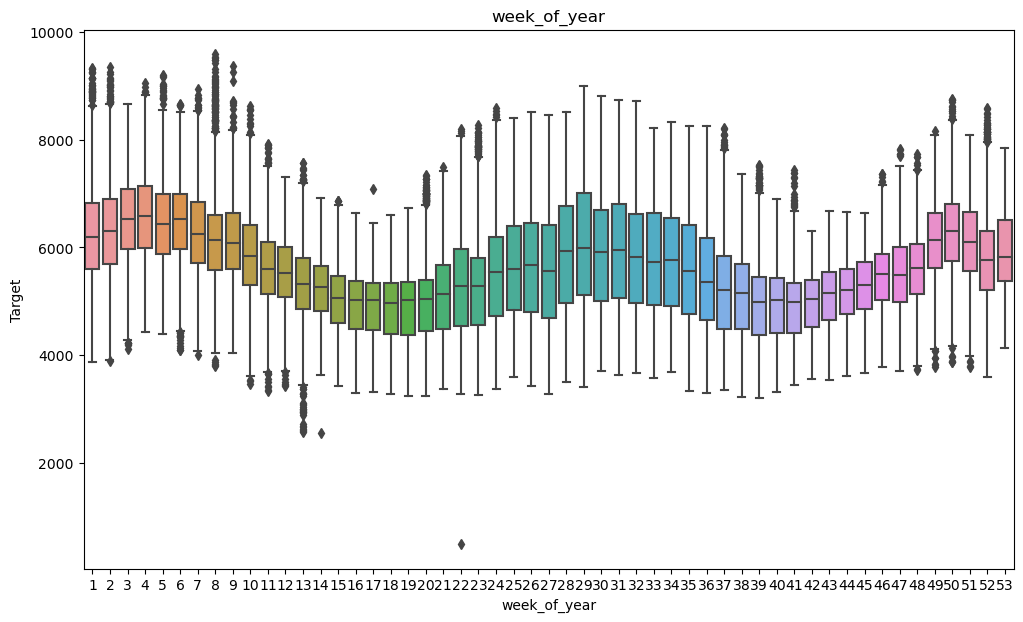

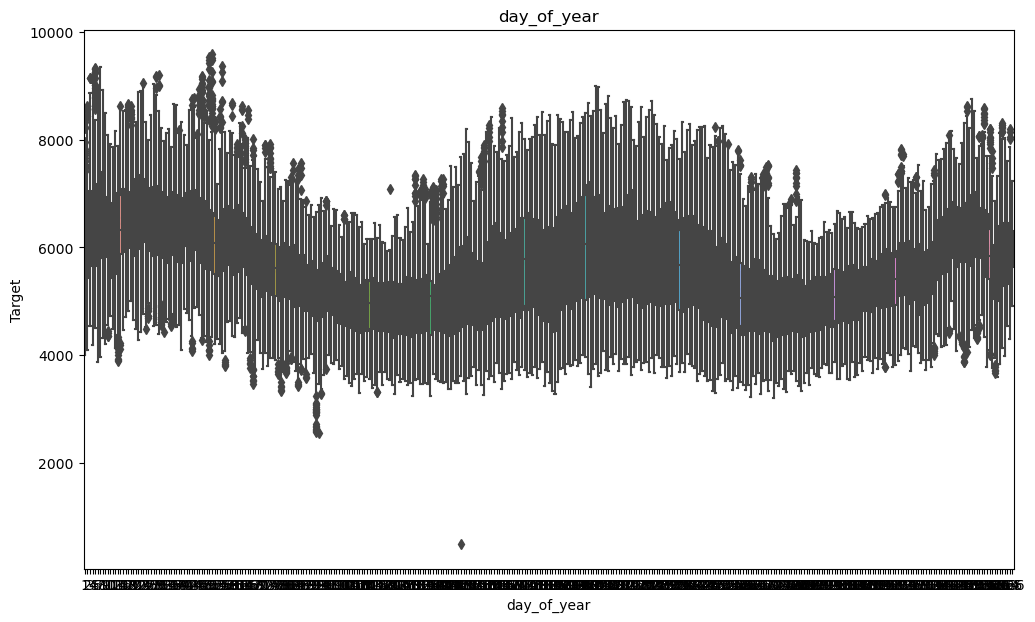

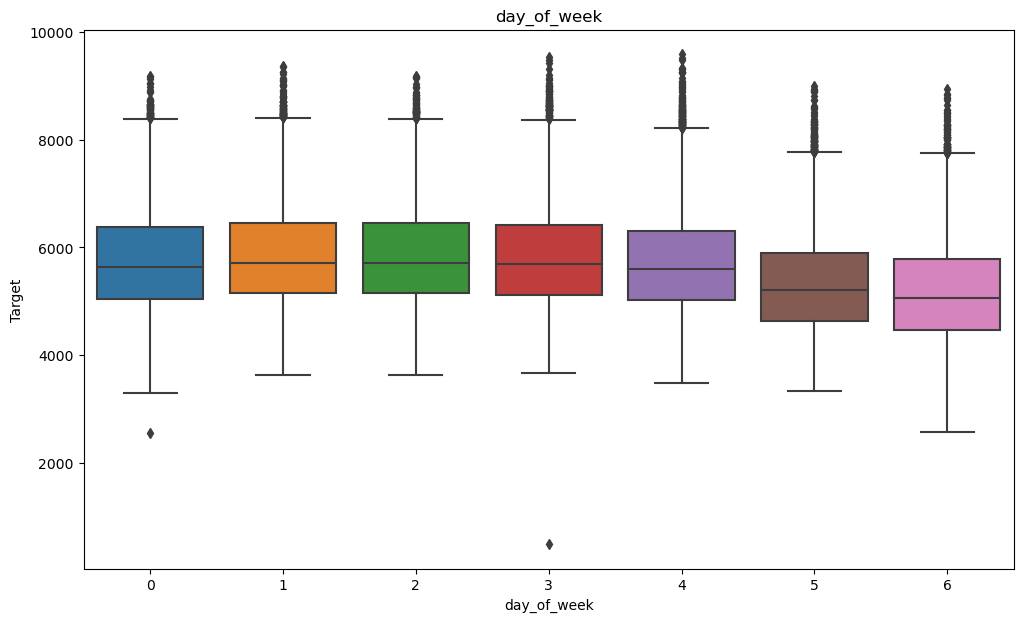

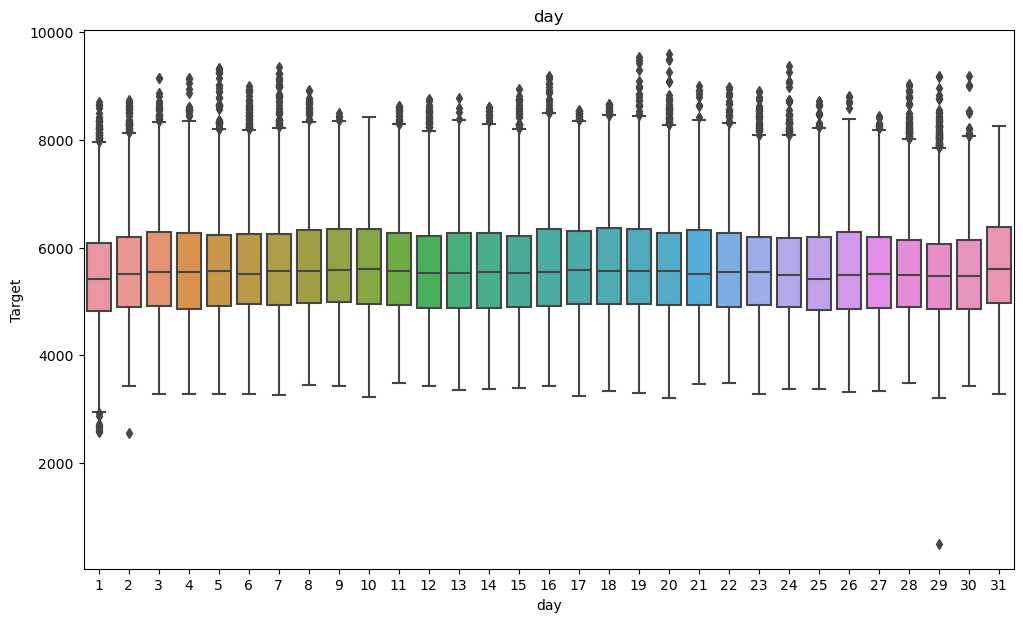

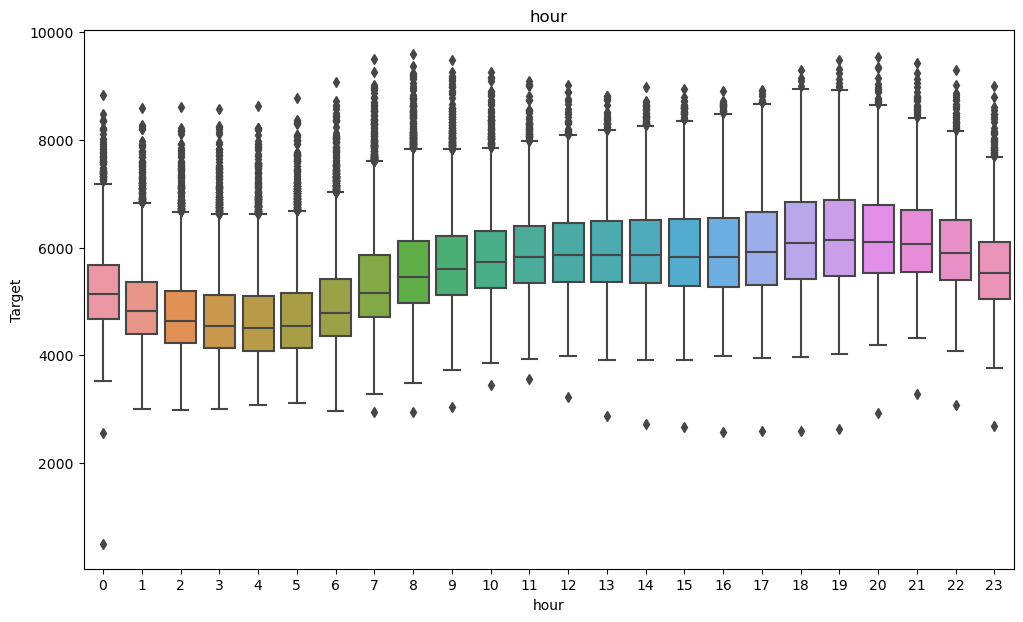

In [6]:
columns = ['year', 'quarter', 'month', 'week_of_year', 'day_of_year', 'day_of_week', 'day', 'hour']
for column in columns:
    plt.figure(figsize = (12, 7))
    plt.title(column)
    sb.boxplot(x = column, y = 'Target', data = df)
    plt.show()

# Skforecast

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

In [8]:
num_of_rows = 1_000
train = df[0:num_of_rows]
test = df[num_of_rows:num_of_rows + 200]

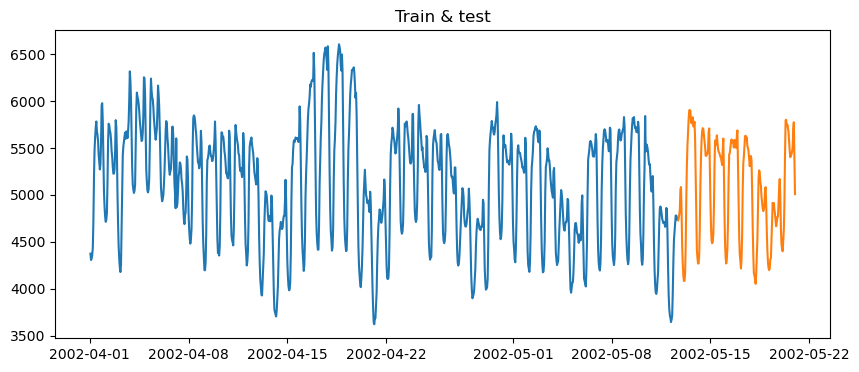

In [9]:
plt.figure(figsize = (10, 4))
plt.title(f'Train & test')
plt.plot(train['Target'])
plt.plot(test['Target'])
plt.show()

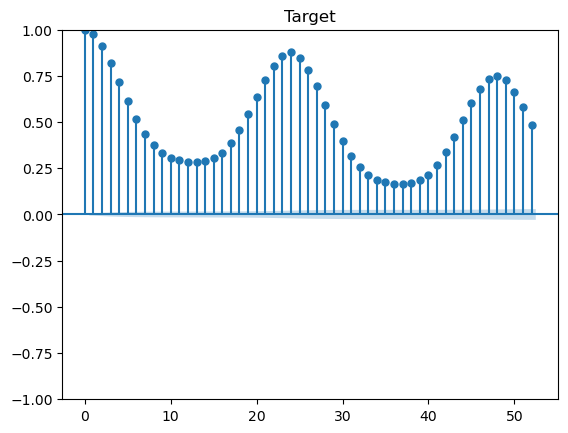

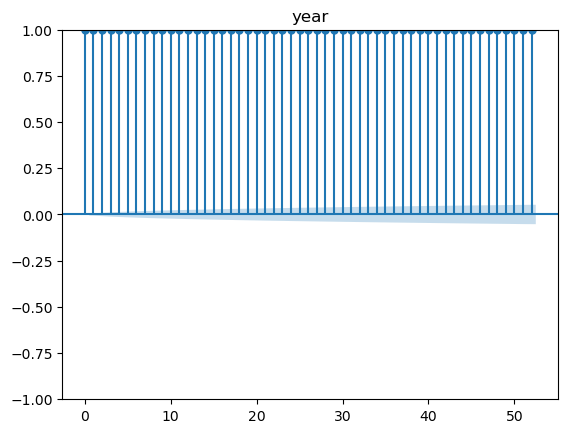

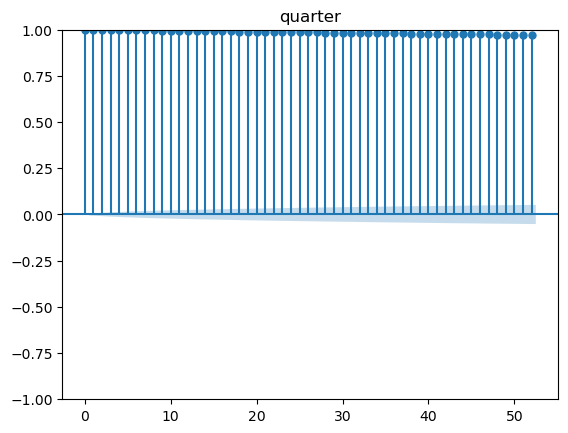

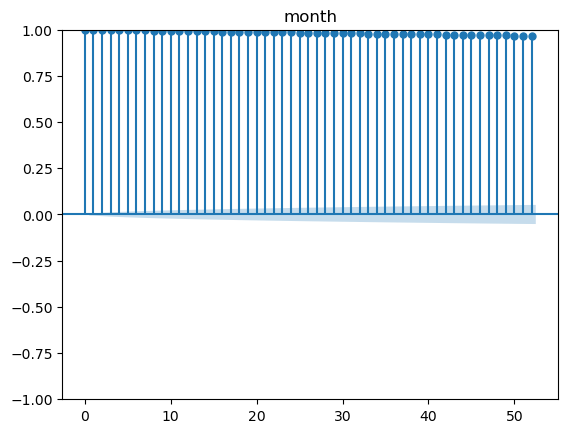

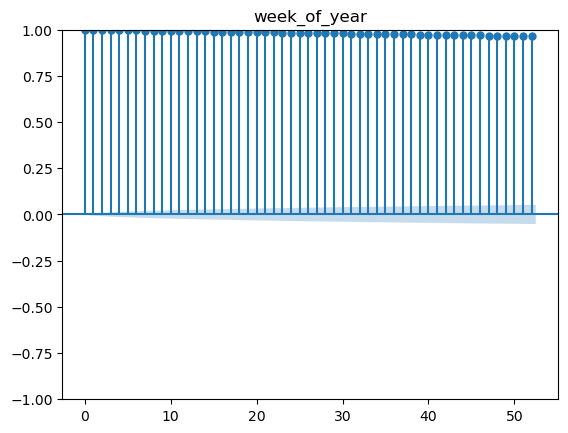

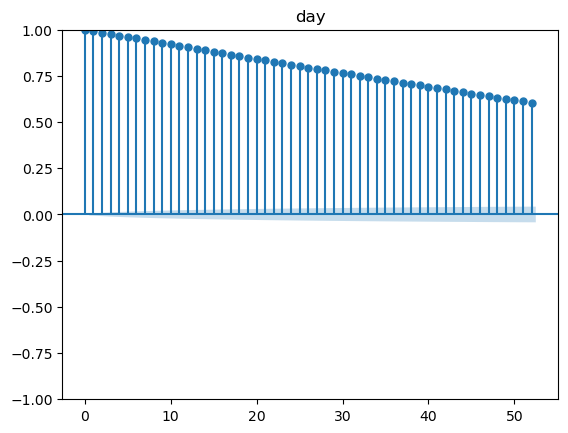

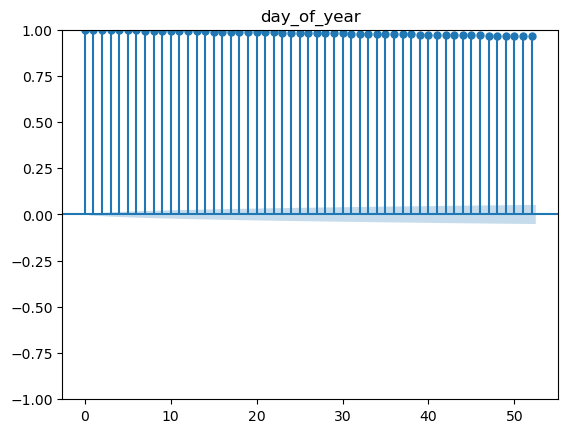

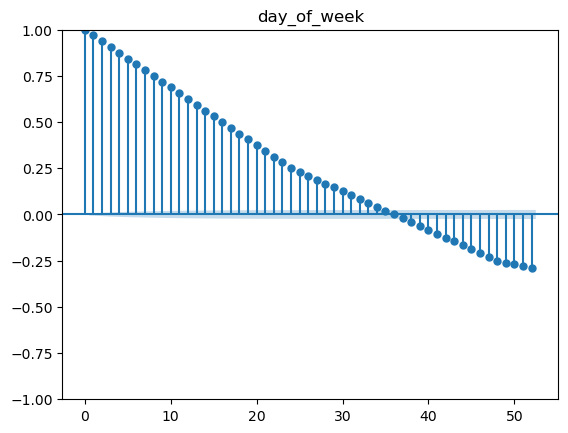

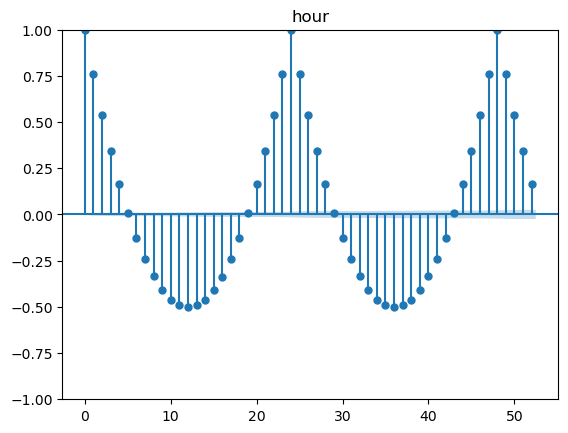

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

for column in df:
    if df[column].dtypes == 'object':
        continue
    plot_acf(df[column].to_numpy(), title = column)
    plt.show()

## ForecasterAutoreg

In [11]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state = 42, n_jobs = -1),
    lags = 24)
forecaster.fit(y = train['Target'])
predictions = forecaster.predict(steps = len(test))

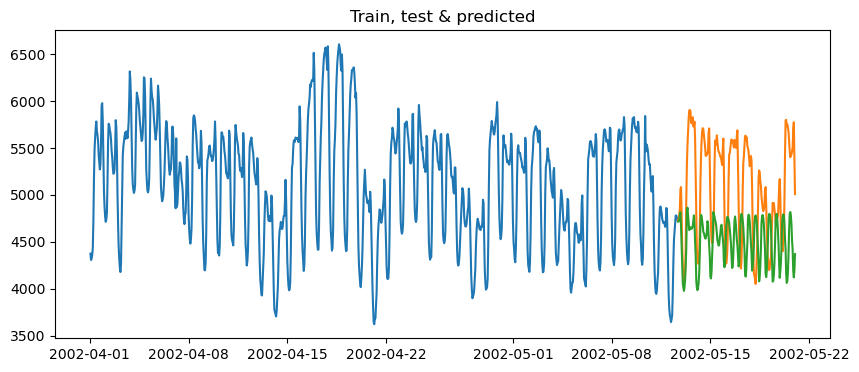

In [12]:
plt.figure(figsize = (10, 4))
plt.title(f'Train, test & predicted')
plt.plot(train['Target'])
plt.plot(test['Target'])
plt.plot(predictions)
plt.show()

In [13]:
print(f"MSE: {mse(test['Target'], predictions)}")
print(f"MAE: {mae(test['Target'], predictions)}")
print(f"MAPE: {mape(test['Target'], predictions)}")

MSE: 637910.3710737933
MAE: 682.7444791738244
MAPE: 0.12896744644335895


### Backtesting

In [15]:
n_backtesting = 200
metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y = train['Target'],
    initial_train_size = len(train) - n_backtesting,
    fixed_train_size = False,
    steps = 200,
    metric = 'mean_squared_error',
    refit = True,
    verbose = True,
    show_progress = True)
print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 800
Number of observations used for backtesting: 200
    Number of folds: 1
    Number of steps per fold: 200
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2002-04-01 01:00:00 -- 2002-05-04 08:00:00  (n=800)
    Validation: 2002-05-04 09:00:00 -- 2002-05-12 16:00:00  (n=200)



  0%|          | 0/1 [00:00<?, ?it/s]

Backtest error: 394755.63376371


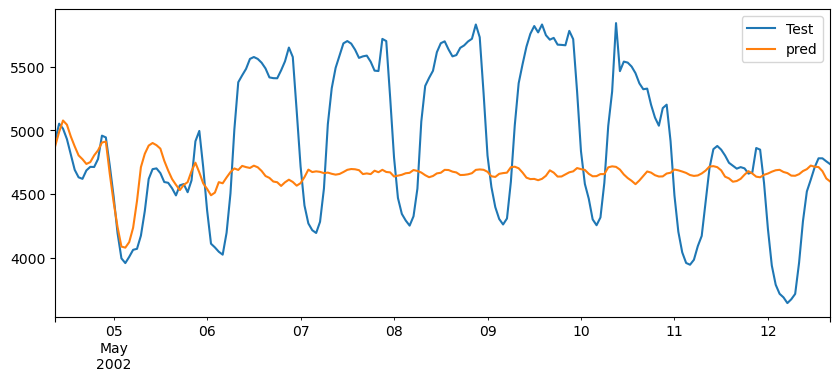

In [16]:
fig, ax = plt.subplots(figsize = (10, 4))
df.loc[predictions_backtest.index, 'Target'].plot(ax = ax, label = 'Test')
predictions_backtest.plot(ax = ax, label = 'Predictions')
ax.legend()

In [17]:
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.897806
1,lag_2,0.005375
2,lag_3,0.007083
3,lag_4,0.004487
4,lag_5,0.003536
5,lag_6,0.001892
6,lag_7,0.001674
7,lag_8,0.001180
8,lag_9,0.001920
9,lag_10,0.004966


## ForecasterAutoreg with exogenous variable

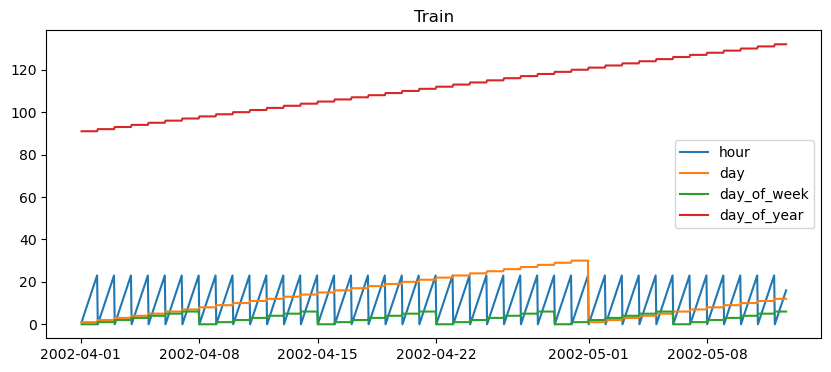

In [24]:
plt.figure(figsize = (10, 4))
plt.title(f'Train')
plt.plot(train['hour'])
plt.plot(train['day'])
plt.plot(train['day_of_week'])
plt.plot(train['day_of_year'])
plt.legend(('hour', 'day', 'day_of_week', 'day_of_year'))
plt.show()

In [26]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state = 42, n_jobs = -1),
    lags = 24)
forecaster.fit(
    y = train['Target'],
    exog = train.drop(columns = 'Target'))
predictions = forecaster.predict(
    steps = len(test),
    exog = test.drop(columns = 'Target'))

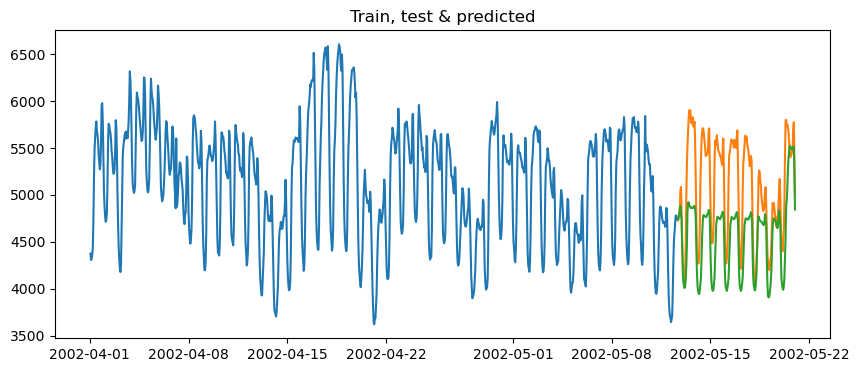

In [27]:
plt.figure(figsize = (10, 4))
plt.title(f'Train, test & predicted')
plt.plot(train['Target'])
plt.plot(test['Target'])
plt.plot(predictions)
plt.show()

In [28]:
print(f"MSE: {mse(test['Target'], predictions)}")
print(f"MAE: {mae(test['Target'], predictions)}")
print(f"MAPE: {mape(test['Target'], predictions)}")

MSE: 375520.0884834704
MAE: 514.8098375214731
MAPE: 0.09777858346658011


### Backtesting

In [29]:
n_backtesting = 200
metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y = train['Target'],
    exog = train.drop(columns = 'Target'),
    initial_train_size = len(train) - n_backtesting,
    fixed_train_size = False,
    steps = 200,
    metric = 'mean_squared_error',
    refit = True,
    verbose = True,
    show_progress = True)
print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 800
Number of observations used for backtesting: 200
    Number of folds: 1
    Number of steps per fold: 200
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2002-04-01 01:00:00 -- 2002-05-04 08:00:00  (n=800)
    Validation: 2002-05-04 09:00:00 -- 2002-05-12 16:00:00  (n=200)



  0%|          | 0/1 [00:00<?, ?it/s]

Backtest error: 31707.512848339895


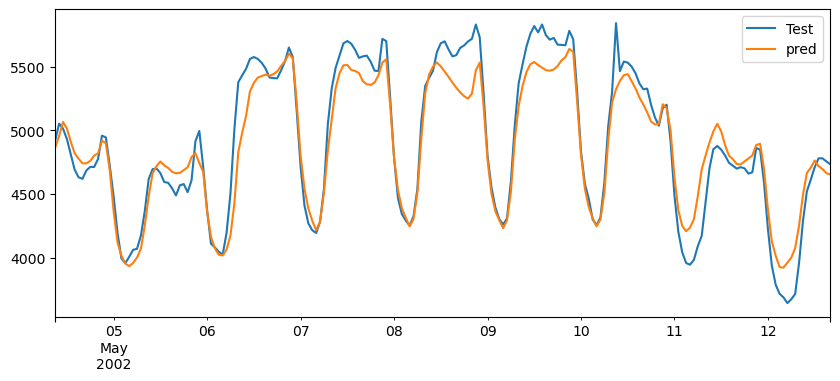

In [30]:
fig, ax = plt.subplots(figsize = (10, 4))
df.loc[predictions_backtest.index, 'Target'].plot(ax = ax, label = 'Test')
predictions_backtest.plot(ax = ax, label = 'Predictions')
ax.legend()

## Prediction intervals

In [34]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state = 42, n_jobs = -1),
    lags = 24)
forecaster.fit(y = train['Target'])
predictions = forecaster.predict_interval(
    random_state = 42,
    steps = 200,
    interval = [1, 99],
    n_boot = 500)
predictions

,pred,lower_bound,upper_bound
2002-05-12 17:00:00,4714.76,4619.96167,4828.840000
2002-05-12 18:00:00,4718.30,4585.19060,4830.310000
2002-05-12 19:00:00,4725.80,4555.83750,4826.263400
2002-05-12 20:00:00,4788.81,4589.38380,4893.908100
2002-05-12 21:00:00,4814.32,4633.35100,4947.577900
...,...,...,...
2002-05-20 20:00:00,4418.54,4039.68390,4807.726200
2002-05-20 21:00:00,4191.44,4006.19250,4798.316400
2002-05-20 22:00:00,4120.59,3985.77440,4812.875042
2002-05-20 23:00:00,4196.50,3973.43710,4826.703500


In [36]:
predictions.iloc[:, 0]

2002-05-12 17:00:00    4714.76
2002-05-12 18:00:00    4718.30
2002-05-12 19:00:00    4725.80
2002-05-12 20:00:00    4788.81
2002-05-12 21:00:00    4814.32
                        ...   
2002-05-20 20:00:00    4418.54
2002-05-20 21:00:00    4191.44
2002-05-20 22:00:00    4120.59
2002-05-20 23:00:00    4196.50
2002-05-21 00:00:00    4369.22
Freq: H, Name: pred, Length: 200, dtype: float64

In [37]:
print(f"MSE: {mse(test['Target'], predictions.iloc[:, 0])}")
print(f"MAE: {mae(test['Target'], predictions.iloc[:, 0])}")
print(f"MAPE: {mape(test['Target'], predictions.iloc[:, 0])}")

MSE: 637910.3710737933
MAE: 682.7444791738244
MAPE: 0.12896744644335895


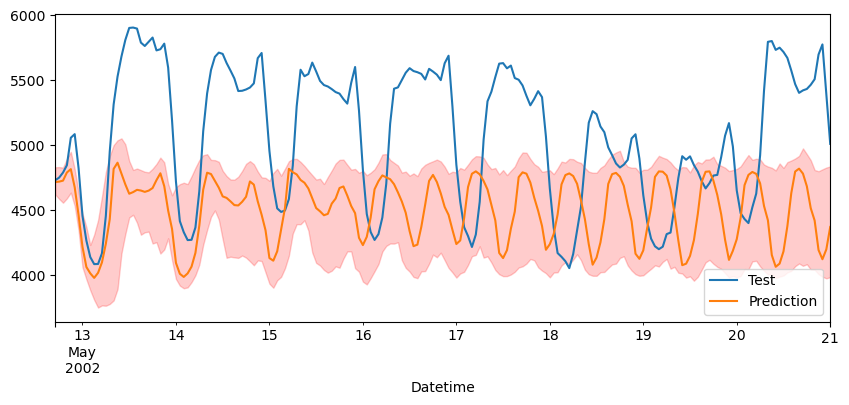

In [39]:
fig, ax = plt.subplots(figsize = (10, 4))
test['Target'].plot(ax = ax, label = 'Test')
predictions['pred'].plot(ax = ax, label = 'Prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2)
ax.legend()
plt.show()

### Backtesting

In [43]:
n_backtesting = 200
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y = train['Target'],
    exog = train.drop(columns = 'Target'),
    initial_train_size = len(train) - n_backtesting,
    fixed_train_size   = False,
    steps              = 200,
    metric             = 'mean_squared_error',
    refit              = True,
    interval           = [1, 99],
    n_boot             = 100,
    n_jobs             = 'auto',
    verbose            = True)
print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 800
Number of observations used for backtesting: 200
    Number of folds: 1
    Number of steps per fold: 200
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2002-04-01 01:00:00 -- 2002-05-04 08:00:00  (n=800)
    Validation: 2002-05-04 09:00:00 -- 2002-05-12 16:00:00  (n=200)



  0%|          | 0/1 [00:00<?, ?it/s]

Backtest error: 31707.512848339895


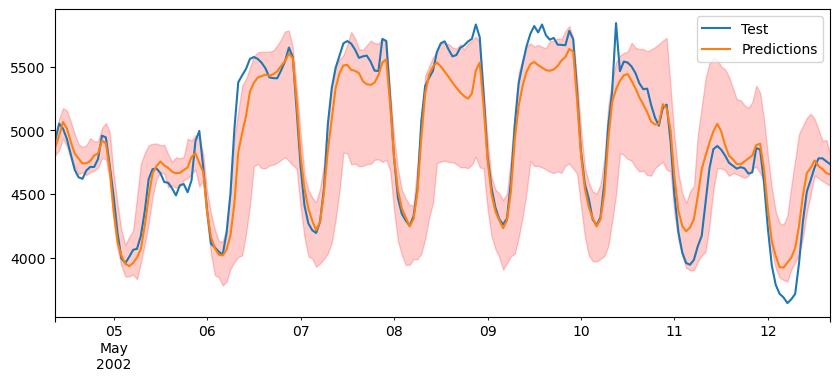

In [44]:
fig, ax = plt.subplots(figsize = (10, 4))
df.loc[predictions.index, 'Target'].plot(ax = ax, label = 'Test')
predictions['pred'].plot(ax = ax, label = 'Predictions')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2)
ax.legend()
plt.show()